In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import signal
from scipy import ndimage
import random as rd
import time
import os
from scipy.optimize import minimize
from PIL import Image, ImageDraw

In [2]:
def secante(f,x0,x1,max_iter,tol):
    i = 0
    if x0 == x1:
        raise Exception("x0 et x1 sont égaux !")
    
    pente = (f(x1)-f(x0))/(x1-x0)
    x_pp,x_p = x0,x1
    x = x1-f(x1)/pente
    while i < max_iter and np.abs(x_p-x) > tol:
        x_p,x_pp = x,x_p
        pente = (f(x_p)-f(x_pp))/(x_p-x_pp)
        x = x-f(x)/pente
        i += 1
    return (x,i)

def float_array_to_RGB_PIL_img(imgdata):
    
    bandarray=imgdata*255/imgdata.max()
    band=Image.fromarray(bandarray.astype(np.uint8),mode="L")
    rgbimg=Image.merge("RGB",[band,band,band])
    
    return rgbimg

def uniform_kernel(radius):
    size = 2*radius+1
    value = 1.0/size**2
    return np.full((size,size),value)
    
def gauss_kernel(sigma,radius):
    
    size = int(2*radius+1)
    t = sigma**2
    
    kernel=np.exp(-np.array([[((i-radius)**2+(j-radius)**2)/(2*t) 
                              for i in range(size)] for j in range(size)],
                                dtype=float))
    kernel = kernel/kernel.sum()
    
    return kernel

def build_source(stype,N,L,mass,extra=None,blur_kernel=gauss_kernel(2,2)):
    
    h = L/N
    img=Image.new("F",(N,N),0)
    draw = ImageDraw.Draw(img)
    cx,cy=N/2,N/2
    adjust_mass = False
    
    if stype=="disk":
        radius = np.sqrt(mass/np.pi)/h
        draw.ellipse([(cx-radius, cy-radius), 
                      (cx+radius, cy+radius)], fill=1)
    elif stype=='ellipse':
        if extra is None:
            ratio = 2
        else:
            ratio = extra['ratio']

        b = np.sqrt(mass/(ratio*np.pi))/h
        a = b*ratio

        draw.ellipse([(cx-a, cy-b), 
                      (cx+a, cy+b)],fill=1)
    elif stype=="disk_with_cusp":
        scaling = 1
        draw.ellipse([(N/2-N/4, N/2-N/4), 
                      (N/2+N/4, N/2+N/4)],fill=1)
        draw.polygon([(N/2-N/8,N/2), (N/2+N/8,N/2),(N/2,15*N/16)],fill=1)
        adjust_mass = True
    elif stype=="rectangle":
        if extra is None:
            ratio = 2
        else:
            ratio = extra['ratio']

        l = np.sqrt(mass/ratio)/h
        L = l*ratio
        cx1,cy1 = (N-L)/2,(N-l)/2
        cx2,cy2 = N-cx1, N-cy1
        draw.rectangle([(cx1,cy1),(cx2,cy2)], fill=1)
    elif stype=="rectangle_high":
        draw.rectangle([(N/4,N*(1.+3./10)/2),(3*N/4,N*(1.+7./10)/2)], 
                       fill=1)
        adjust_mass = True
    elif stype=="square":
        extra['ratio'] = 1
        return build_source("rectangle",N,L,mass,extra=extra,
                            blur_kernel=blur_kernel)
    elif stype=="annulus":
        if extra is None:
            rmin = 1.
        else:
            rmin = extra['rmin']
        rmax = np.sqrt(mass/np.pi+rmin**2)
        rmin,rmax = rmin/h,rmax/h

        draw.ellipse([(cx-rmax, cx-rmax), 
                      (cx+rmax, cx+rmax)],fill=1)
        draw.ellipse([(cx-rmin, cx-rmin), 
                      (cx+rmin, cx+rmin)],fill=0)
    elif stype=='annulus_with_cusp':
        draw.ellipse([(N/4,N/4),(3*N/4.,3*N/4)],fill=1)
        draw.ellipse([(3*N/8,3*N/8),(5*N/8.,5*N/8)],fill=0)
        draw.polygon([(N/2+N/16, N/4+N/16), (3*N/4, N/4), 
                      (3*N/4-N/16, N/2-N/16)],fill=1)
        adjust_mass = True
    elif stype=="half_disk":
        draw.chord([(N/4,N*(1.-1./2)/2),(3*N/4,N*(1.+1./2)/2)],
                   180,360,fill=1)
        adjust_mass = True
    elif stype=="triangle":
        if extra is None:
            ratio = 2
        else:
            ratio = extra['ratio']
        B = np.sqrt(2*mass*ratio)/h
        H = B/ratio
        cx1,cy1 = (N-B)/2,(N+H)/2
        cx2,cy2 = N-cx1,(N+H)/2
        cx3,cy3 = N/2,N-cy1
        draw.polygon([(cx1,cy1),(cx2,cy2),(cx3,cy3)],fill=1)
    elif stype=="pacman":
        draw.chord([(N/4,N*(1.-1./2)/2),(3*N/4,N*(1.+1./2)/2)],
                   30,90,fill=1)
        draw.chord([(N/4,N*(1.-1./2)/2),(3*N/4,N*(1.+1./2)/2)],
                   270,330,fill=1)
        draw.chord([(N/4,N*(1.-1./2)/2),(3*N/4,N*(1.+1./2)/2)],
                   90,270,fill=1)
        draw.polygon([(N/2,N/2), 
                      (N/2+N*np.cos(np.pi/6)/4,N/2+N*np.sin(np.pi/6)/4), 
                      (N/2+N*np.cos(np.pi/2)/4,N/2+N*np.sin(np.pi/2)/4)],
                     fill=1)
        draw.polygon([(N/2,N/2), 
                      (N/2+N*np.cos(-np.pi/6)/4,N/2+N*np.sin(-np.pi/6)/4), 
                      (N/2+N*np.cos(-np.pi/2)/4,N/2+N*np.sin(-np.pi/2)/4)],
                     fill=1)
        draw.ellipse([(N/2,N*0.3),(N/2.+N/10.,N*0.3+N/10)],fill=0)
        adjust_mass = True
    elif stype=="pacman_mod":
        draw.chord([(N/4,N*(1.-2/3)/2),(3*N/4,N*(1.+2/3)/2)],
                   30,90,fill=1)
        draw.chord([(N/4,N*(1.-2/3)/2),(3*N/4,N*(1.+2/3)/2)],
                   270,330,fill=1)
        draw.chord([(N/4,N*(1.-2/3)/2),(3*N/4,N*(1.+2/3)/2)],
                   90,270,fill=1)
        draw.polygon([(N/2,N/2), 
                      (N/2+N*np.cos(np.pi/6)/4,N/2+N*np.sin(np.pi/6)/4), 
                      (N/2+N*np.cos(np.pi/2)/4,N/2+N*np.sin(np.pi/2)/4)],
                     fill=1)
        draw.polygon([(N/2,N/2), 
                      (N/2+N*np.cos(-np.pi/6)/4,N/2+N*np.sin(-np.pi/6)/4), 
                      (N/2+N*np.cos(-np.pi/2)/4,N/2+N*np.sin(-np.pi/2)/4)],
                     fill=1)
        draw.ellipse([(N/2,N*0.3),(N/2.+N/7.,N*0.3+N/7)],fill=0)
        adjust_mass = True
    else:
        raise Exception("Unknown source type.")

    mu=np.asarray(img)

    if adjust_mass:
        m = mu.sum()*h**2
        scaling = np.sqrt(mass/m)

        img = img.resize((int(N*scaling),int(N*scaling)),
                         resample=Image.Resampling.NEAREST)
        w,h = img.size
        delta = int((w-N)/2)
        img = img.crop((delta,delta,delta+N,delta+N)) 
        mu = np.asarray(img)
    
    try:
        angle = extra['rotate']
        img = img.rotate(angle,resample=Image.Resampling.NEAREST)
        mu = np.asarray(img)
    except:
        pass
    
    if blur_kernel is not None:
        mu=signal.convolve2d(mu, blur_kernel, boundary="wrap", mode="same")

    return mu

colors = ['#ffffff', '#ffb3b3', '#b3b3ff']
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

In [3]:
def exterior_transport(mu,eps, L, threshold=1e-5, max_iter=1000, 
                       gibbs_kernel=None,init=None):
    
    (N,N_)=mu.shape
    h = L/N
    mu = mu*h**2
    ones = np.ones_like(mu)
    
    if init is not None:
        vecA = init['A']
        vecB = init['B']
    else:
        vecA = np.ones_like(mu)
        vecB = np.ones_like(mu)
    
    oneminusmu=h**2*np.ones_like(mu)-mu
    
    gibbs_kernel = np.array([[np.exp(-((i1-j1)*h)**2/eps) 
                              for i1 in range(0,N)] 
                             for j1 in range(0,N)])
    
    val = -1e6
    k = 0
    while k < max_iter:
        vecB_bar = oneminusmu*vecB
        vecBp=gibbs_kernel@vecB_bar@gibbs_kernel
        vecA=np.divide(ones,vecBp,out=np.ones_like(mu), where=vecBp!=0)
        
        vecA_bar = mu*vecA
        vecAp = gibbs_kernel@vecA_bar@gibbs_kernel
        vecB = np.divide(np.minimum(ones,vecAp),vecAp,out=np.ones_like(mu), 
                         where=vecAp!=0)
        
        margin = (mu.T@(eps*np.log(vecA))).trace()+\
                        (oneminusmu.T@(eps*np.log(vecB))).trace()
        dual_rem = eps*(
            vecB_bar.T@gibbs_kernel@vecA_bar@gibbs_kernel).trace()
        prev_val, val = val, margin - dual_rem
        if np.abs((prev_val-val)/val) <= threshold:
            break
        k += 1

    mass = mu.sum()
    phi = eps*np.log(vecA)
    psi = eps*np.log(vecB) 
    vecB_bar = oneminusmu*vecB
    vecA_bar = mu*vecA
    vecGamma = (gibbs_kernel@vecA_bar@gibbs_kernel)*vecB_bar
    
    cost_kernel = np.array([[((i1-j1)*h)**2*np.exp(-((i1-j1)*h)**2/eps)
                          for i1 in range(0,N)] 
                         for j1 in range(0,N)])

    transport_cost = (vecB_bar.T@cost_kernel@vecA_bar@gibbs_kernel).trace()\
                    +(vecB_bar.T@gibbs_kernel@vecA_bar@cost_kernel).trace()

    return (transport_cost, vecGamma, phi, psi, vecA, vecB)

In [4]:
W = lambda s: 0.5*s**2*((1-s)**2)
Wp = lambda s: s*(s-1)*(2*s-1)
Phi = lambda s: (3-2*s)*s**2/6
NormPhi = lambda s: 6*Phi(s)



def double_well_with_forcing_explicit(U, t, eps, xi):
    
    U_w = U*(1-U)*(1-2*U)
    U_s = U - t*(U_w/eps+xi)
    return U_s

def compute_allen_cahn_energy(U,eps,h):
    
    U0 = (U-np.roll(U,1,axis=0))
    U1 = (U-np.roll(U,1,axis=1))
    grad = U0**2+U1**2
    
    return eps*np.sum(grad)/2 + np.sum(W(U))*h**2/eps

def compute_2D_discrete_diffusion_factor(N,delta_x,delta_y,time_step):
    
    freqx = np.fft.fftfreq(N, delta_x)
    freqx = np.fft.fftshift(freqx)
    kx = freqx
    kx2d = np.repeat(kx, N)
    kx2d.shape = (N,N)

    freqy = np.fft.fftfreq(N, delta_y)
    freqy = np.fft.fftshift(freqy)
    ky = freqy
    ky2d = np.repeat(ky, N)
    ky2d.shape = (N,N)
    ky2d = ky2d.T

    symbol = -4*(np.sin(np.pi*kx2d*delta_x)**2/delta_x**2
                 +np.sin(np.pi*ky2d*delta_y)**2/delta_y**2)
    
    return np.exp(symbol*time_step)

def apply_factor_fft(U,factor):
    
    U_f = np.fft.fft2(U)
    U_f = np.fft.fftshift(U_f)
    U_f = U_f*factor
    U_f = np.fft.ifftshift(U_f)
    U_s = np.fft.ifft2(U_f)
    
    return U_s.real

def compute_total_energy(U, eps, h, c, eps_transport, L, usePhi=True):

    if usePhi:
        energy_ups, U_ext, phi, psi, A, B= exterior_transport(NormPhi(U), eps_transport, L)
    else:
        energy_ups, U_ext, phi, psi, A, B= exterior_transport(U, eps_transport, L)
    
    return 6*compute_allen_cahn_energy(U,eps,h) + c*energy_ups


def get_AC_Wasserstein_explicit(U_0, m, t, eps, eps_transport, L, c_W, usePhi=True):
    
    N = U_0.shape[0]
    h = L/N
    U = U_0
    diffusion_factor = compute_2D_discrete_diffusion_factor(N, h, h, eps*t)
    
    def step_func(U,init=None):
        
        U = apply_factor_fft(U, diffusion_factor)
        U[U < 0] = 0
        U[U > 1] = 1
        
        if usePhi:
            energy_ups,U_ext, phi, psi, A, B = exterior_transport(NormPhi(U), eps_transport, L,init=init)
        else:
            energy_ups,U_ext, phi, psi, A, B = exterior_transport(U, eps_transport, L,init=init)
        
        if usePhi:
            U = double_well_with_forcing_explicit(U, t, eps, c_W*(phi-psi)*U*(1-U))
            def optim_func(lmb):
                return np.sum(NormPhi(U+lmb*U*(1-U)))*h**2-m
            lmb,nb_iter = secante(optim_func,0,0.1,100,1e-8)
            U = U+lmb*U*(1-U)

        else:
            U = double_well_with_forcing_explicit(U, t, eps, c_W*(phi-psi)/6)
            def optim_func(lmb):
                return np.sum(U+lmb)*h**2-m
            lmb,nb_iter = secante(optim_func,0,0.1,100,1e-8)
            U = U+lmb
        
        total_energy = 6*compute_allen_cahn_energy(U,eps,h)+c_W*energy_ups

        return U,total_energy,{'A' : A, 'B': B}
    
    
    return step_func

In [5]:
def compute_total_energy(U, eps, h, c, eps_transport, L, usePhi=True):

    if usePhi:
        energy_ups, U_ext, phi, psi, A, B= exterior_transport(NormPhi(U), eps_transport, L)
    else:
        energy_ups, U_ext, phi, psi, A, B= exterior_transport(U, eps_transport, L)
    
    return 6*compute_allen_cahn_energy(U,eps,h) + c*energy_ups

### 2.a. AC + Wass : Behaviours near the ball and the annulus

In [6]:
m = np.pi
N = 256
L = 4
rmin = 0.2
U_0 = build_source('annulus', N, L, m, extra={'rmin':rmin})
h = L/N
eps = 2*h
eps_transport = 1e-2
time_step = eps/2
nb_iter = 100
c = 5.54

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)

U_1 = U_0
list_E1 = [energy_init]


step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

i= 0  E= 13.670439581880743
i= 10  E= 12.411196112037121
i= 20  E= 12.354705726716475
i= 30  E= 12.320526392772338
i= 40  E= 12.29638350041022
i= 50  E= 12.278447522280219
i= 60  E= 12.264339402208641
i= 70  E= 12.25282894606092
i= 80  E= 12.242843745251577
i= 90  E= 12.233904410997543
i= 100  prev_E =  12.227256985027257  E= 12.226447132210788
Time elapsed  25.76163625717163


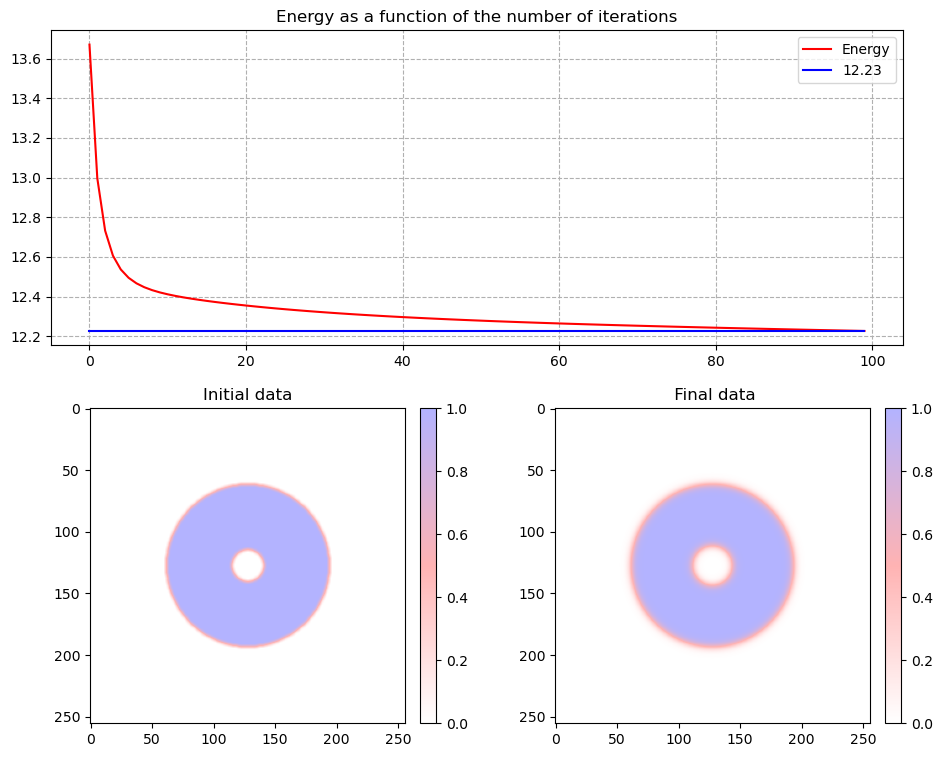

In [7]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)


im01 = axL.imshow(U_0, cmap=cmap)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Energy')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
#axT.set_yscale('log')
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')


im10 = axR.imshow(U_1, cmap=cmap)
im10.set_clim(0,1)
axR.set_title(" Final data")
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()

In [9]:
m = np.pi
N = 256
L = 4
U_0 = build_source('disk_with_cusp', N, L, m)
h = L/N
min_density = 0
max_density = 1-min_density
eps = 2*h
eps_transport = 1e-2
time_step = eps/2
nb_iter = 100
c = 1

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)

U_1 = U_0
list_E1 = [energy_init]

print('time_step', time_step)

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E_1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-6)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end_ball = time.time()
print("Time elapsed ", end - start)

ini = "{:.2f}".format(list_E1[0])
end_ball = "{:.2f}".format(list_E1[-1])

time_step 0.015625
i= 0  E= 9.085942401401917
i= 10  E= 7.818153345794466
i= 20  E= 7.692329800355806
i= 30  E= 7.610085731265412
i= 40  E= 7.550156388213374
i= 50  E= 7.506377858884488
i= 60  E= 7.474412270995232
i= 70  E= 7.450890969743875
i= 80  E= 7.433317542644305
i= 90  E= 7.419853134057725
i= 100  prev_E =  7.411195967336907  E= 7.410224039158481
Time elapsed  -129.54802775382996


In [10]:
m = np.pi
N = 256
L = 4
rmin = 0.5
U_0_lsmall = build_source('annulus', N, L, m, extra={'rmin':rmin})
h = L/N
min_density = 0
max_density = 1-min_density
eps = 2*h
eps_transport = 1e-2
time_step = eps/2
nb_iter = 100
c = 1

energy_init_lsmall = compute_total_energy(U_0_lsmall, eps, h, c, 
                                   eps_transport, L)

U_1_lsmall = U_0_lsmall
list_E1_lsmall = [energy_init_lsmall]

print('time_step', time_step)

step_function_1 = get_AC_Wasserstein_explicit(U_0_lsmall, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1_lsmall,E1_lsmall = 0,-1
while i < nb_iter and (not np.isclose(E1_lsmall,prev_E1_lsmall,rtol=1e-6)):
    prev_E1_lsmall = E1_lsmall
    U_1_lsmall,E1_lsmall,extra = step_function_1(U_1_lsmall,init)
    init = extra
    list_E1_lsmall.append(E1_lsmall)
    if i % mod == 0:
        print("i=",i, " E=", E1_lsmall)
    i += 1
print("i=",i, " prev_E = ", prev_E1_lsmall," E=", E1_lsmall)
end = time.time()
print("Time elapsed ", end - start)

ini_lsmall = "{:.2f}".format(list_E1_lsmall[0])
end_lsmall = "{:.2f}".format(list_E1_lsmall[-1])

time_step 0.015625
i= 0  E= 12.111436294876631
i= 10  E= 10.59643926707458
i= 20  E= 10.51378375318537
i= 30  E= 10.439566970697204
i= 40  E= 10.367669461178668
i= 50  E= 10.29324651311028
i= 60  E= 10.219914452191219
i= 70  E= 10.147823903407168
i= 80  E= 10.07427278585927
i= 90  E= 9.999748446563643
i= 100  prev_E =  9.940411355818158  E= 9.933759587946701
Time elapsed  30.617470264434814


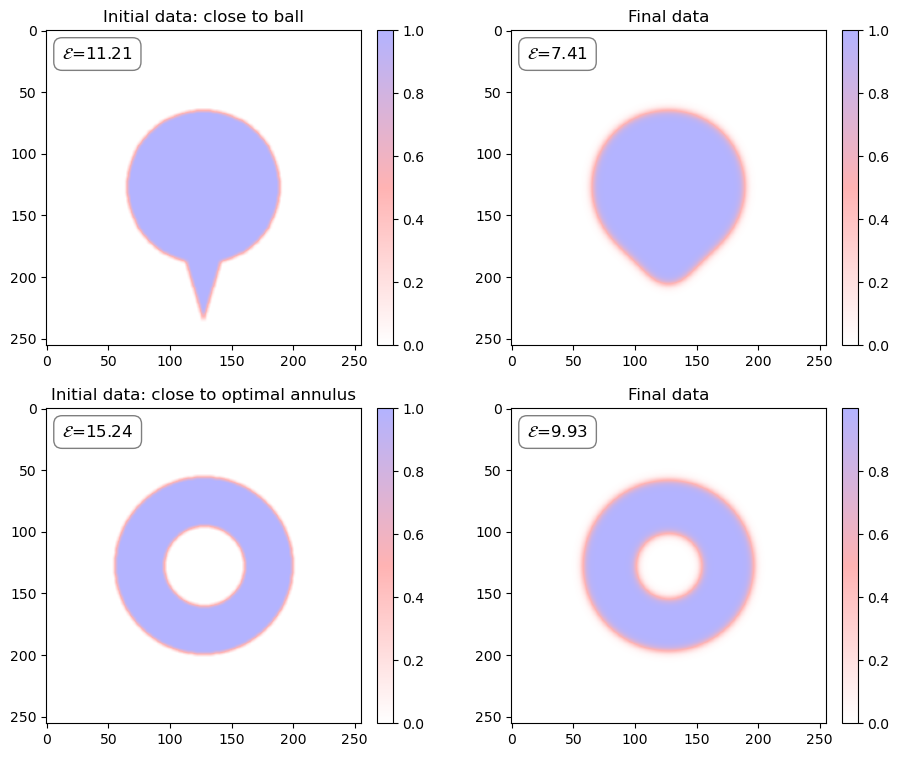

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(11, 9))

im1 = ax[0, 0].imshow(U_0, cmap=cmap)
ax[0, 0].set_title('Initial data: close to ball')
plt.colorbar(im1, ax=ax[0, 0], fraction=0.046, pad=0.04)
ax[0, 0].text(0.05, 0.95, '$\mathcal{E}$=' + str(ini), 
              transform=ax[0, 0].transAxes,  # Use axes coordinates
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

im2 = ax[0, 1].imshow(U_1, cmap=cmap)
ax[0, 1].set_title('Final data')
plt.colorbar(im2, ax=ax[0, 1], fraction=0.046, pad=0.04)
ax[0, 1].text(0.05, 0.95, '$\mathcal{E}$=' + str(end_ball), 
              transform=ax[0, 1].transAxes,
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

im3 = ax[1, 0].imshow(U_0_lsmall, cmap=cmap)
ax[1, 0].set_title('Initial data: close to optimal annulus')
plt.colorbar(im3, ax=ax[1, 0], fraction=0.046, pad=0.04)
ax[1, 0].text(0.05, 0.95, '$\mathcal{E}$=' + str(ini_lsmall), 
              transform=ax[1, 0].transAxes,
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

im4 = ax[1, 1].imshow(U_1_lsmall, cmap=cmap)
ax[1, 1].set_title('Final data')
plt.colorbar(im4, ax=ax[1, 1], fraction=0.046, pad=0.04)
ax[1, 1].text(0.05, 0.95, '$\mathcal{E}$=' + str(end_lsmall), 
              transform=ax[1, 1].transAxes,
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.savefig('critical_case')
plt.show()

In [12]:
print(end)

1731081916.7713678


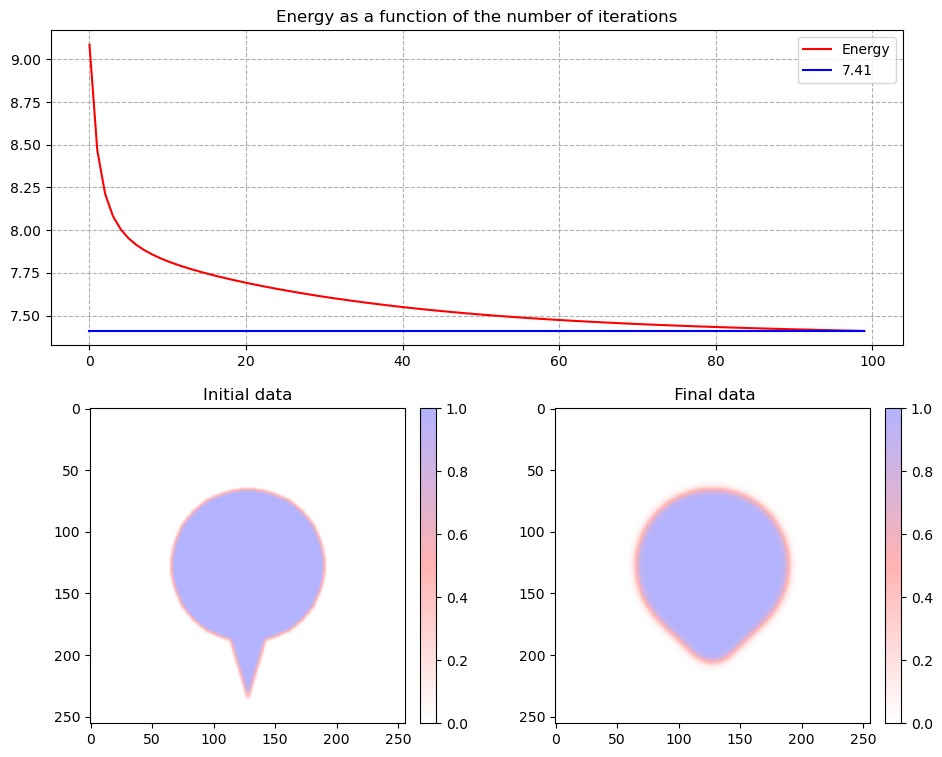

In [13]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)

im01 = axL.imshow(U_0, cmap=cmap)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Energy')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
#axT.set_yscale('log')
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')


im10 = axR.imshow(U_1, cmap=cmap)
im10.set_clim(0,1)
axR.set_title(" Final data")
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()

### 2.b. AC + Wass : The critical regime

In [14]:
#close to the ball

m = np.pi
N = 256
L = 4
rmin = 0.1
U_0 = build_source('annulus', N, L, m, extra={'rmin':rmin})
h = L/N

eps = 2*h
eps_transport = 1e-2
time_step = (1/2)*eps/5
nb_iter = 100
c= 10
#c = 6 such that ball and ring of almost same energy
#Emin = Eball = Ering = 11.861
#rmin = 0.381, rmax = 1.07

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1 = [energy_init]

print('time_step', time_step)

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

time_step 0.003125
i= 0  E= 19.486572212535513
i= 10  E= 17.044085810761402
i= 20  E= 16.711760802202114
i= 30  E= 16.584097119175162
i= 40  E= 16.50648563811405
i= 50  E= 16.446290571403992
i= 60  E= 16.393569582490393
i= 70  E= 16.344577703744413
i= 80  E= 16.296892543395018
i= 90  E= 16.24965790469573
i= 100  prev_E =  16.211735327962426  E= 16.206995577600228
Time elapsed  35.581385135650635


In [15]:
m = np.pi
N = 256
L = 4
U_0_lsmall = build_source('annulus_with_cusp', N, L, m)
h = L/N
min_density = 0
max_density = 1-min_density
eps = 2*h
eps_transport = 1e-2
time_step = eps/10
nb_iter = 100
c = 15

energy_init_lsmall = compute_total_energy(U_0_lsmall, eps, h, c, 
                                   eps_transport, L)

U_1_lsmall = U_0_lsmall
list_E1_lsmall = [energy_init_lsmall]

print('time_step', time_step)

step_function_1 = get_AC_Wasserstein_explicit(U_0_lsmall, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1_lsmall,E1_lsmall = 0,-1
while i < nb_iter and (not np.isclose(E1_lsmall,prev_E1_lsmall,rtol=1e-6)):
    prev_E1_lsmall = E1_lsmall
    U_1_lsmall,E1_lsmall,extra = step_function_1(U_1_lsmall,init)
    init = extra
    list_E1_lsmall.append(E1_lsmall)
    if i % mod == 0:
        print("i=",i, " E=", E1_lsmall)
    i += 1
print("i=",i, " prev_E = ", prev_E1_lsmall," E=", E1_lsmall)
end = time.time()
print("Time elapsed ", end - start)

ini_lsmall = "{:.2f}".format(list_E1_lsmall[0])
end_lsmall = "{:.2f}".format(list_E1_lsmall[-1])

time_step 0.003125
i= 0  E= 19.32993653868543
i= 10  E= 16.1609773255076
i= 20  E= 15.816849584894637
i= 30  E= 15.731058610936788
i= 40  E= 15.696273343126872
i= 50  E= 15.67591798490125
i= 60  E= 15.661111524888167
i= 70  E= 15.649017358521156
i= 80  E= 15.63864652847705
i= 90  E= 15.629476658908839
i= 100  prev_E =  15.622786984552455  E= 15.621985554887168
Time elapsed  27.7014000415802


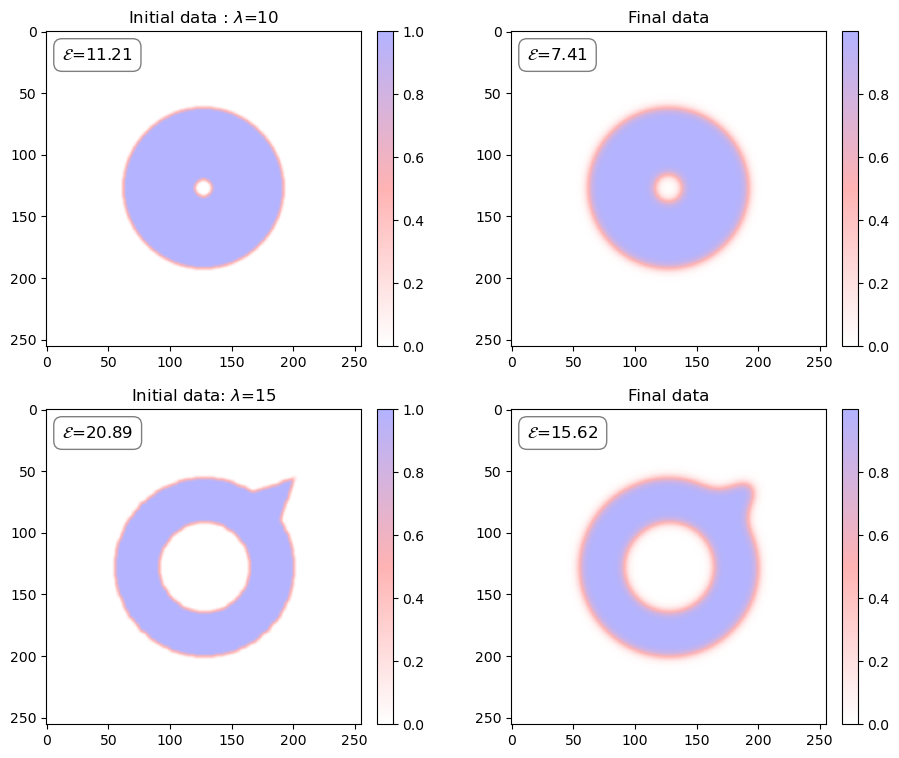

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(11, 9))

im1 = ax[0, 0].imshow(U_0, cmap=cmap)
ax[0, 0].set_title('Initial data : $\lambda$=10')
plt.colorbar(im1, ax=ax[0, 0], fraction=0.046, pad=0.04)
ax[0, 0].text(0.05, 0.95, '$\mathcal{E}$=' + str(ini), 
              transform=ax[0, 0].transAxes,  # Use axes coordinates
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

im2 = ax[0, 1].imshow(U_1, cmap=cmap)
ax[0, 1].set_title('Final data')
plt.colorbar(im2, ax=ax[0, 1], fraction=0.046, pad=0.04)
ax[0, 1].text(0.05, 0.95, '$\mathcal{E}$=' + str(end_ball), 
              transform=ax[0, 1].transAxes,
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

im3 = ax[1, 0].imshow(U_0_lsmall, cmap=cmap)
ax[1, 0].set_title('Initial data: $\lambda$=15')
plt.colorbar(im3, ax=ax[1, 0], fraction=0.046, pad=0.04)
ax[1, 0].text(0.05, 0.95, '$\mathcal{E}$=' + str(ini_lsmall), 
              transform=ax[1, 0].transAxes,
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

im4 = ax[1, 1].imshow(U_1_lsmall, cmap=cmap)
ax[1, 1].set_title('Final data')
plt.colorbar(im4, ax=ax[1, 1], fraction=0.046, pad=0.04)
ax[1, 1].text(0.05, 0.95, '$\mathcal{E}$=' + str(end_lsmall), 
              transform=ax[1, 1].transAxes,
              fontsize=12,
              verticalalignment='top',
              horizontalalignment='left',
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.savefig('critical_case')
plt.show()

In [17]:
#close to the annulus

m = np.pi
N = 256
L = 4
h = L/N
eps = 2*h
eps_transport = 1e-2
time_step = (1/5)*eps*(1/2)
nb_iter = 100
c= 5.54

rmin = 0.4
U_0 = build_source('annulus', N, L, m, extra={'rmin':rmin})

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1 = [energy_init]

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

i= 0  E= 14.868287186390805
i= 10  E= 12.27015176388452
i= 20  E= 12.01368307777846
i= 30  E= 11.963932884735325
i= 40  E= 11.951716974131134
i= 50  E= 11.948197818645166
i= 60  E= 11.947020474115348
i= 70  E= 11.946561665051561
i= 80  E= 11.946348677891136
i= 90  E= 11.946225968146027
i= 100  prev_E =  11.946153538969378  E= 11.946145305838629
Time elapsed  30.516634225845337


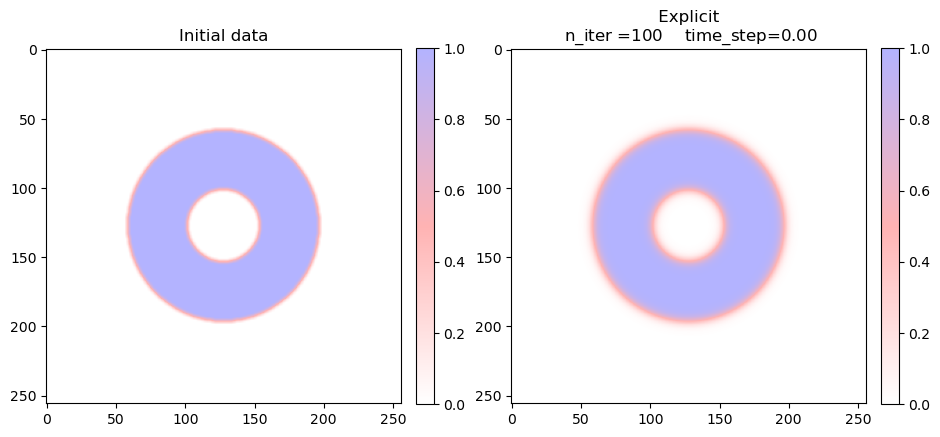

In [18]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axL = fig.add_subplot(1,2, 1)
axR = fig.add_subplot(1, 2, 2)

im01 = axL.imshow(U_0, cmap=cmap)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

init = list_E1[0]
lim = list_E1[-1]


im10 = axR.imshow(U_1, cmap=cmap)
im10.set_clim(0,1)
axR.set_title(" Explicit \n n_iter ="+\
                   str(nb_iter)+"$\quad$ time_step="+str("{:.2f}".format(time_step)))
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)
plt.show()
plt.close()

### 2.c. AC + Wass : Rigidity of the ball and the annulus

In [19]:
#disk with cusp

m = np.pi
N = 256
L = 4
U_0 = build_source('disk_with_cusp', N, L, m)
h = L/N
eps = 2*h
eps_transport = 1e-2
time_step = (1/2)*eps/5
nb_iter = 100
c= 1.


energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1, list_E2 = [energy_init], []

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

i= 0  E= 10.41804401445394
i= 10  E= 8.215473492487884
i= 20  E= 7.961665496014191
i= 30  E= 7.877944948772945
i= 40  E= 7.829315531197137
i= 50  E= 7.792325315269199
i= 60  E= 7.761134876569741
i= 70  E= 7.733667382769987
i= 80  E= 7.708902193151956
i= 90  E= 7.686240251617769
i= 100  prev_E =  7.669341964099317  E= 7.66729835647945
Time elapsed  29.90079379081726


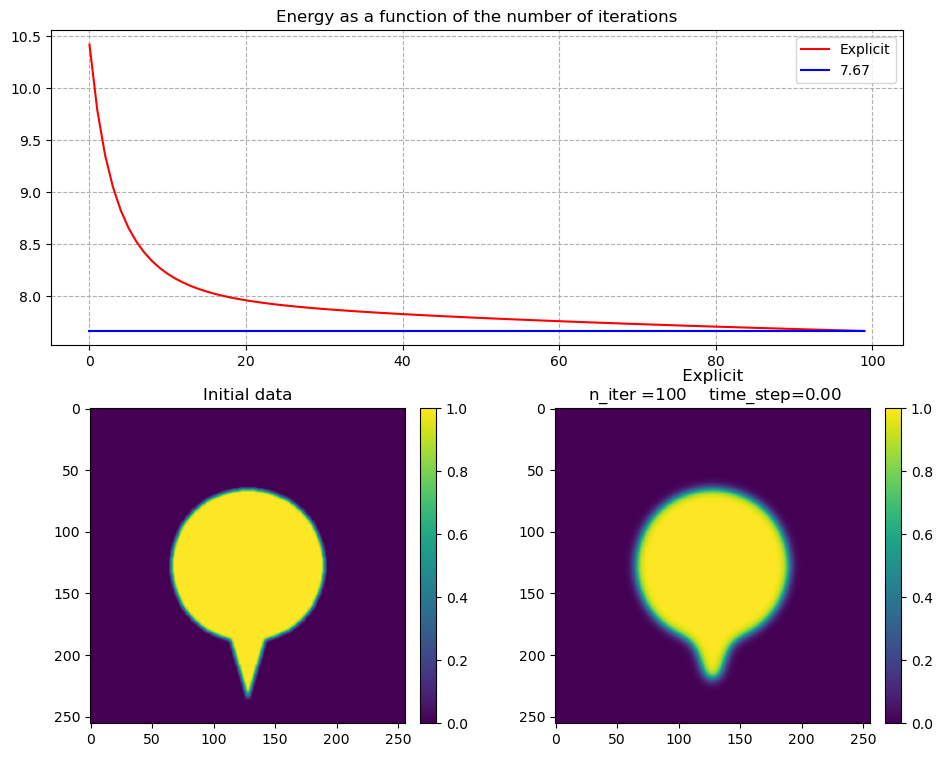

In [20]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)

U_0_100 = U_0.copy()
U_1_100 = U_1.copy()

im01 = axL.imshow(U_0)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Explicit')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')

im10 = axR.imshow(U_1)
im10.set_clim(0,1)
axR.set_title(" Explicit \n n_iter ="+\
                   str(nb_iter)+"$\quad$ time_step="+str("{:.2f}".format(time_step)))
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()

In [21]:
#annulus with cusp

m = np.pi
N = 256
L = 4
U_0 = build_source('annulus_with_cusp', N, L, m)
h = L/N
min_density = 0
max_density = 1-min_density
eps = 2*h
eps_transport = 1e-2
time_step = (1/2)*eps/10
nb_iter = 100
c= 10.

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1, list_E2 = [energy_init], []

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-12)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

i= 0  E= 18.458524885132913
i= 10  E= 15.346923761684245
i= 20  E= 14.63610148328318
i= 30  E= 14.383078345000861
i= 40  E= 14.272313884017123
i= 50  E= 14.21611997208125
i= 60  E= 14.183602412472487
i= 70  E= 14.162307532594292
i= 80  E= 14.14662292387985
i= 90  E= 14.134061407070607
i= 100  prev_E =  14.125394547981129  E= 14.124374217042497
Time elapsed  29.535476684570312


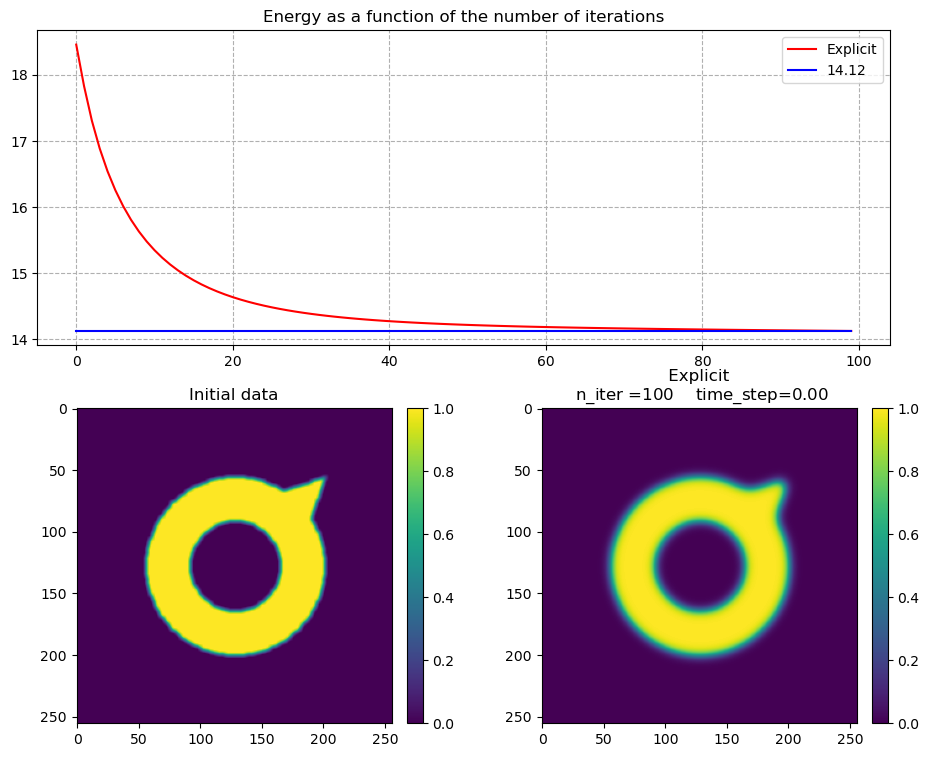

In [22]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)

im01 = axL.imshow(U_0)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Explicit')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')

im10 = axR.imshow(U_1)
im10.set_clim(0,1)
axR.set_title(" Explicit \n n_iter ="+\
                   str(nb_iter)+"$\quad$ time_step="+str("{:.2f}".format(time_step)))
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()

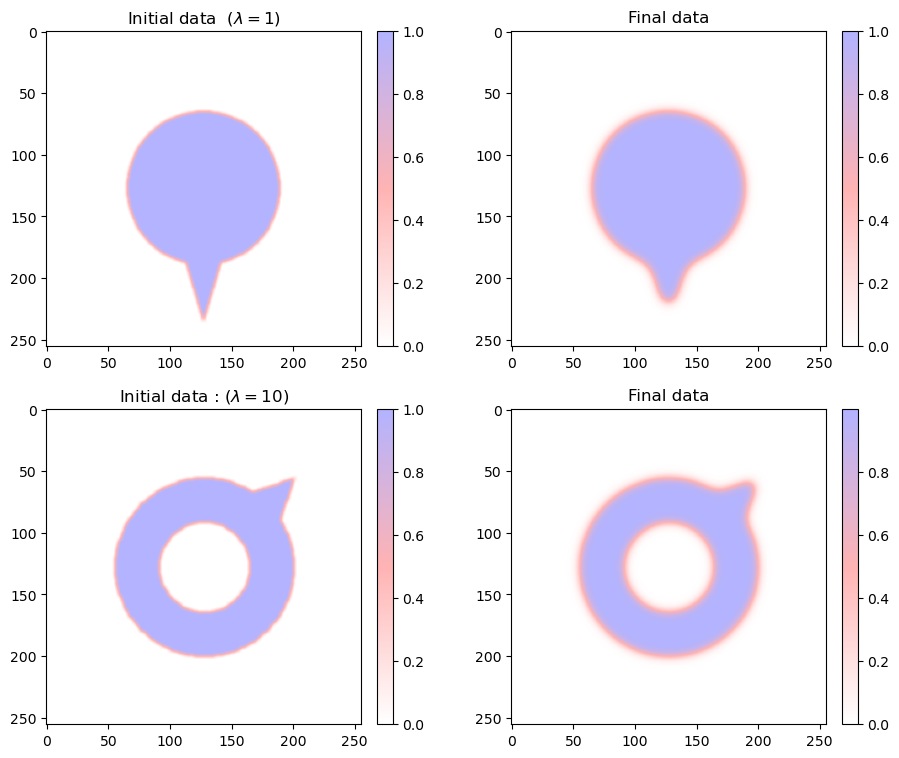

In [23]:
fig , ax = plt.subplots(2,2, figsize=(11,9))

im1 = ax[0,0].imshow(U_0_100, cmap=cmap)
ax[0,0].set_title('Initial data  ($\lambda = 1$)')
plt.colorbar(im1, ax=ax[0,0], fraction=0.046, pad=0.04)

im2= ax[0,1].imshow(U_1_100, cmap=cmap)
ax[0,1].set_title('Final data')
plt.colorbar(im2, ax=ax[0,1], fraction=0.046, pad=0.04)

im3 = ax[1,0].imshow(U_0, cmap=cmap)
ax[1,0].set_title('Initial data : ($\lambda =10$)')
plt.colorbar(im3, ax=ax[1,0], fraction=0.046, pad=0.04)

im4 = ax[1,1].imshow(U_1, cmap=cmap)
ax[1,1].set_title('Final data')
plt.colorbar(im4, ax=ax[1,1], fraction=0.046, pad=0.04)

plt.savefig('stability_ball_ring')
plt.show()

### 2.d. AC + Wass : Starting away from radially symmetric sets

In [24]:
# ellipse

m = np.pi
N = 256
L = 8
U_0 = build_source('ellipse', N, L, m, extra={'ratio':2.5})
h = L/N
eps = 2*h
eps_transport = 1e-2
time_step = (1/5)*eps/2
nb_iter = 100
c= 10.

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1, list_E2 = [energy_init], []

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

np.save('long_ellipse_N' + str(N) + '_lambda' + f'{c:.3f}'+ '_nbiter'+ str(nb_iter) + '.npy', U_1)

i= 0  E= 18.265449699393685
i= 10  E= 15.280054485348476
i= 20  E= 14.887965137713069
i= 30  E= 14.722810012684537
i= 40  E= 14.618220451189794
i= 50  E= 14.547767107510584
i= 60  E= 14.496827450279755
i= 70  E= 14.438408771736782
i= 80  E= 14.392140859112924
i= 90  E= 14.350886705485859
i= 100  prev_E =  14.318809622544839  E= 14.315178821325265
Time elapsed  31.613122940063477


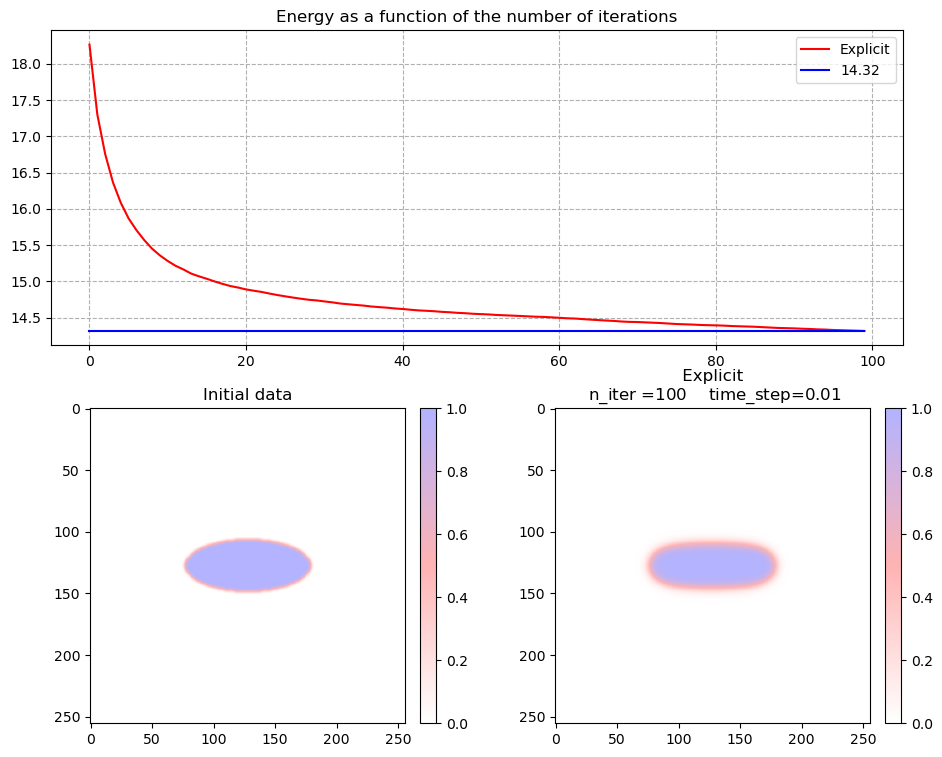

In [25]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)

im01 = axL.imshow(U_0, cmap=cmap)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Explicit')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')

im10 = axR.imshow(U_1, cmap=cmap)
im10.set_clim(0,1)
axR.set_title(" Explicit \n n_iter ="+\
                   str(nb_iter)+"$\quad$ time_step="+str("{:.2f}".format(time_step)))
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()

In [26]:
# long ellipse c

m = np.pi
N = 256
L = 8
U_0 = build_source('ellipse', N, L, m, extra={'ratio':3.5})
h = L/N
eps = 2*h
eps_transport = 1e-2
time_step = (1/5)*eps/2
nb_iter = 100
c= 10.


energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1, list_E2 = [energy_init], []

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

i= 0  E= 18.322423684510376
i= 10  E= 14.60935261427127
i= 20  E= 14.181210921720995
i= 30  E= 14.026157584284237
i= 40  E= 13.933343801549524
i= 50  E= 13.875833156289621
i= 60  E= 13.836713825755115
i= 70  E= 13.793222069708923
i= 80  E= 13.751950335734435
i= 90  E= 13.728013292755321
i= 100  prev_E =  13.708859144331592  E= 13.706812978008978
Time elapsed  32.08465838432312


In [27]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)

im01 = axL.imshow(U_0, cmap=cmap)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Explicit')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')

im10 = axR.imshow(U_1, cmap=cmap)
im10.set_clim(0,1)
axR.set_title("Final data)
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()

SyntaxError: unterminated string literal (detected at line 23) (2927675500.py, line 23)

In [ ]:
#  ellipse c big

m = np.pi
N = 256
L = 8
U_0 = build_source('ellipse', N, L, m, extra={'ratio':3.5})
h = L/N
eps = 2*h
eps_transport = 1e-2
time_step = (1/5)*eps/2
nb_iter = 100
c= 10.

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1, list_E2 = [energy_init], []

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

np.save('long_ellipse_N' + str(N) + '_lambda' + f'{c:.3f}'+ '_nbiter'+ str(nb_iter) + '.npy', U_1)

In [ ]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)

im01 = axL.imshow(U_0)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Explicit')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')

im10 = axR.imshow(U_1)
im10.set_clim(0,1)
axR.set_title(" Explicit \n n_iter ="+\
                   str(nb_iter)+"$\quad$ time_step="+str("{:.2f}".format(time_step)))
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()

In [ ]:
#Pacman
m = np.pi
N = 256
L = 8
U_0 = build_source('pacman', N, L, m)
h = L/N
eps = 2*h
eps_transport = 1e-2
time_step = (1/5)*eps/2
nb_iter = 100
c=10.

energy_init = compute_total_energy(U_0, eps, h, c, 
                                   eps_transport, L)
U_1 = U_0
list_E1 = [energy_init]

step_function_1 = get_AC_Wasserstein_explicit(U_0, m, time_step, eps, 
                                              eps_transport, L, c_W=c)

nb_prints = 10
mod = nb_iter/nb_prints
start = time.time()
init = None
i = 0
prev_E1,E1 = 0,-1
while i < nb_iter and (not np.isclose(E1,prev_E1,rtol=1e-8)):
    prev_E1 = E1
    U_1,E1,extra = step_function_1(U_1,init)
    init = extra
    list_E1.append(E1)
    if i % mod == 0:
        print("i=",i, " E=", E1)
    i += 1
print("i=",i, " prev_E = ", prev_E1," E=", E1)
end = time.time()
print("Time elapsed ", end - start)

np.save('pacman_N' + str(N) + '_lambda' + f'{c:.3f}'+ '_nbiter'+ str(nb_iter) + '.npy', U_1)

In [ ]:
fig  = plt.figure(num=1, clear=True, figsize=(11,9))
axT  = fig.add_subplot(2, 1, 1)
axL = fig.add_subplot(2, 2, 3)
axR = fig.add_subplot(2, 2, 4)

U_0_150 = U_0.copy()
U_1_150 = U_1.copy()

im01 = axL.imshow(U_0_150)
im01.set_clim(0,1)
axL.set_title("Initial data")
plt.colorbar(im01, ax=axL, fraction=0.046, pad=0.04)

list_E1 = list_E1[1:]

N1 = range(len(list_E1))
lim = list_E1[-1]
im1 = axT.plot(N1, list_E1, 'r', label='Explicit')
im2 = axT.plot(N1, [lim for k in N1], 'b', label=str("{:.2f}".format(lim)))
axT.legend(loc='upper right')
axT.set_title("Energy as a function of the number of iterations")
axT.grid(linestyle='--')

im10 = axR.imshow(U_1_150)
im10.set_clim(0,1)
axR.set_title(" Explicit \n n_iter ="+\
                   str(nb_iter)+"$\quad$ time_step="+str("{:.2f}".format(time_step)))
plt.colorbar(im10, ax=axR, fraction=0.046, pad=0.04)

plt.show()
plt.close()